Notebook to calculate grid adjacency and do p-class clustering for Rosi's MPAS aquaplanet grid.

James Ruppert  
9/1/2025

### Main settings

In [3]:
import xarray as xr
import numpy as np
import dask.array as da
import pickle
import matplotlib.pyplot as plt

In [54]:
do_process_clusters = False
# do_process_clusters = True

exp_names = ["CTL","HOMO_RAD","CLIM_RAD"]
ntest = len(exp_names)
pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN', 'DSA']
pclass_names_long = ['DeepC', 'Congest', 'Shallow', 'Stratiform', 'Anvil', 'DSA']
nclass = len(pclass_names)

#### Set paths, read initial conditions, find tropical indexes

In [5]:
grid_path = "/glade/work/rberrios/MPAS/aqua_sstmax10N_ASD/plus4K/TC_3km/x5.tropical_3km_10N.init.nc"
grid = xr.open_dataset(grid_path)
areaCell = grid.areaCell
ncell = areaCell.shape[0] # m^2

latCell = np.degrees(grid.latCell)
lonCell = np.degrees(grid.lonCell)

#find indexes within desired latitudinal range
# latbounds = [15, 20.0]
latbounds = [0, 15.0]
ind_within_lat = np.where( (latCell >= latbounds[0]) & (latCell <= latbounds[1]) )[0]

### Main driver loop

#### Start loops

In [55]:
# %%time

pickle_file_out = f"/glade/derecho/scratch/ruppert/tc-crfrad/pickle_out/pclass_cluster_all.pickle"

if do_process_clusters:

    # Get list of desired file times
    file_times_arr = np.arange('2000-05-01T06:00:00', '2000-05-11T06:00:00', 6, dtype='datetime64[h]')
    file_times = [file_times_arr[i].astype('datetime64[D]').astype(str)+'_'+str(file_times_arr[i]).split('T')[1].split(':')[0]+'.00.00' for i in range(len(file_times_arr))]
    ntime = len(file_times)

    numbers = np.zeros((ntest, ntime, nclass))
    # mean_sizes = np.zeros((ntest, ntime, ncell, nclass))
    mean_sizes = np.zeros((ntest, ntime, nclass))

    for itest, expName in enumerate(exp_names):
    # for itest, expName in enumerate(exp_names[0:1]):

        pickle_dir = f"/glade/derecho/scratch/ruppert/tc-crfrad/mpas/{expName}"

        for it, time in enumerate(file_times):
        # for it, time in enumerate(file_times[0:4]):

            # Read pickles
            pickle_file_in = f"{pickle_dir}/pclass_cluster_{expName}_{time}.pickle"
            with open(pickle_file_in, 'rb') as f:
                lists = pickle.load(f)

            # Object count
            numbers[itest, it, :] = lists[1]

            for iclass in range(nclass):
                labels_write = lists[0][iclass]
                # assume labels_write has the same shape as cellarea
                unique_labels = np.unique(labels_write)
                # ignore background/no-label
                unique_labels = unique_labels[unique_labels >= 1]
                # compute weighted cluster size
                cluster_area = np.bincount(labels_write, weights=areaCell)
                # restrict to valid labels only
                cluster_area = cluster_area[unique_labels]
                mean_sizes[itest, it, iclass] = np.sqrt(np.mean(cluster_area)) # m^2 --> m

        print(f"Finished processing {expName}")

    print('Processing complete.')

    # Write out to pickle
    with open(pickle_file_out, 'wb') as f:
        # pickle.dump(PE_thisExp, f)
        pickle.dump([numbers, mean_sizes], f)

else:

    # Read from pickle
    with open(pickle_file_out, 'rb') as f:
        arrays = pickle.load(f)

    numbers = arrays[0]
    mean_sizes = arrays[1]

### Plotting

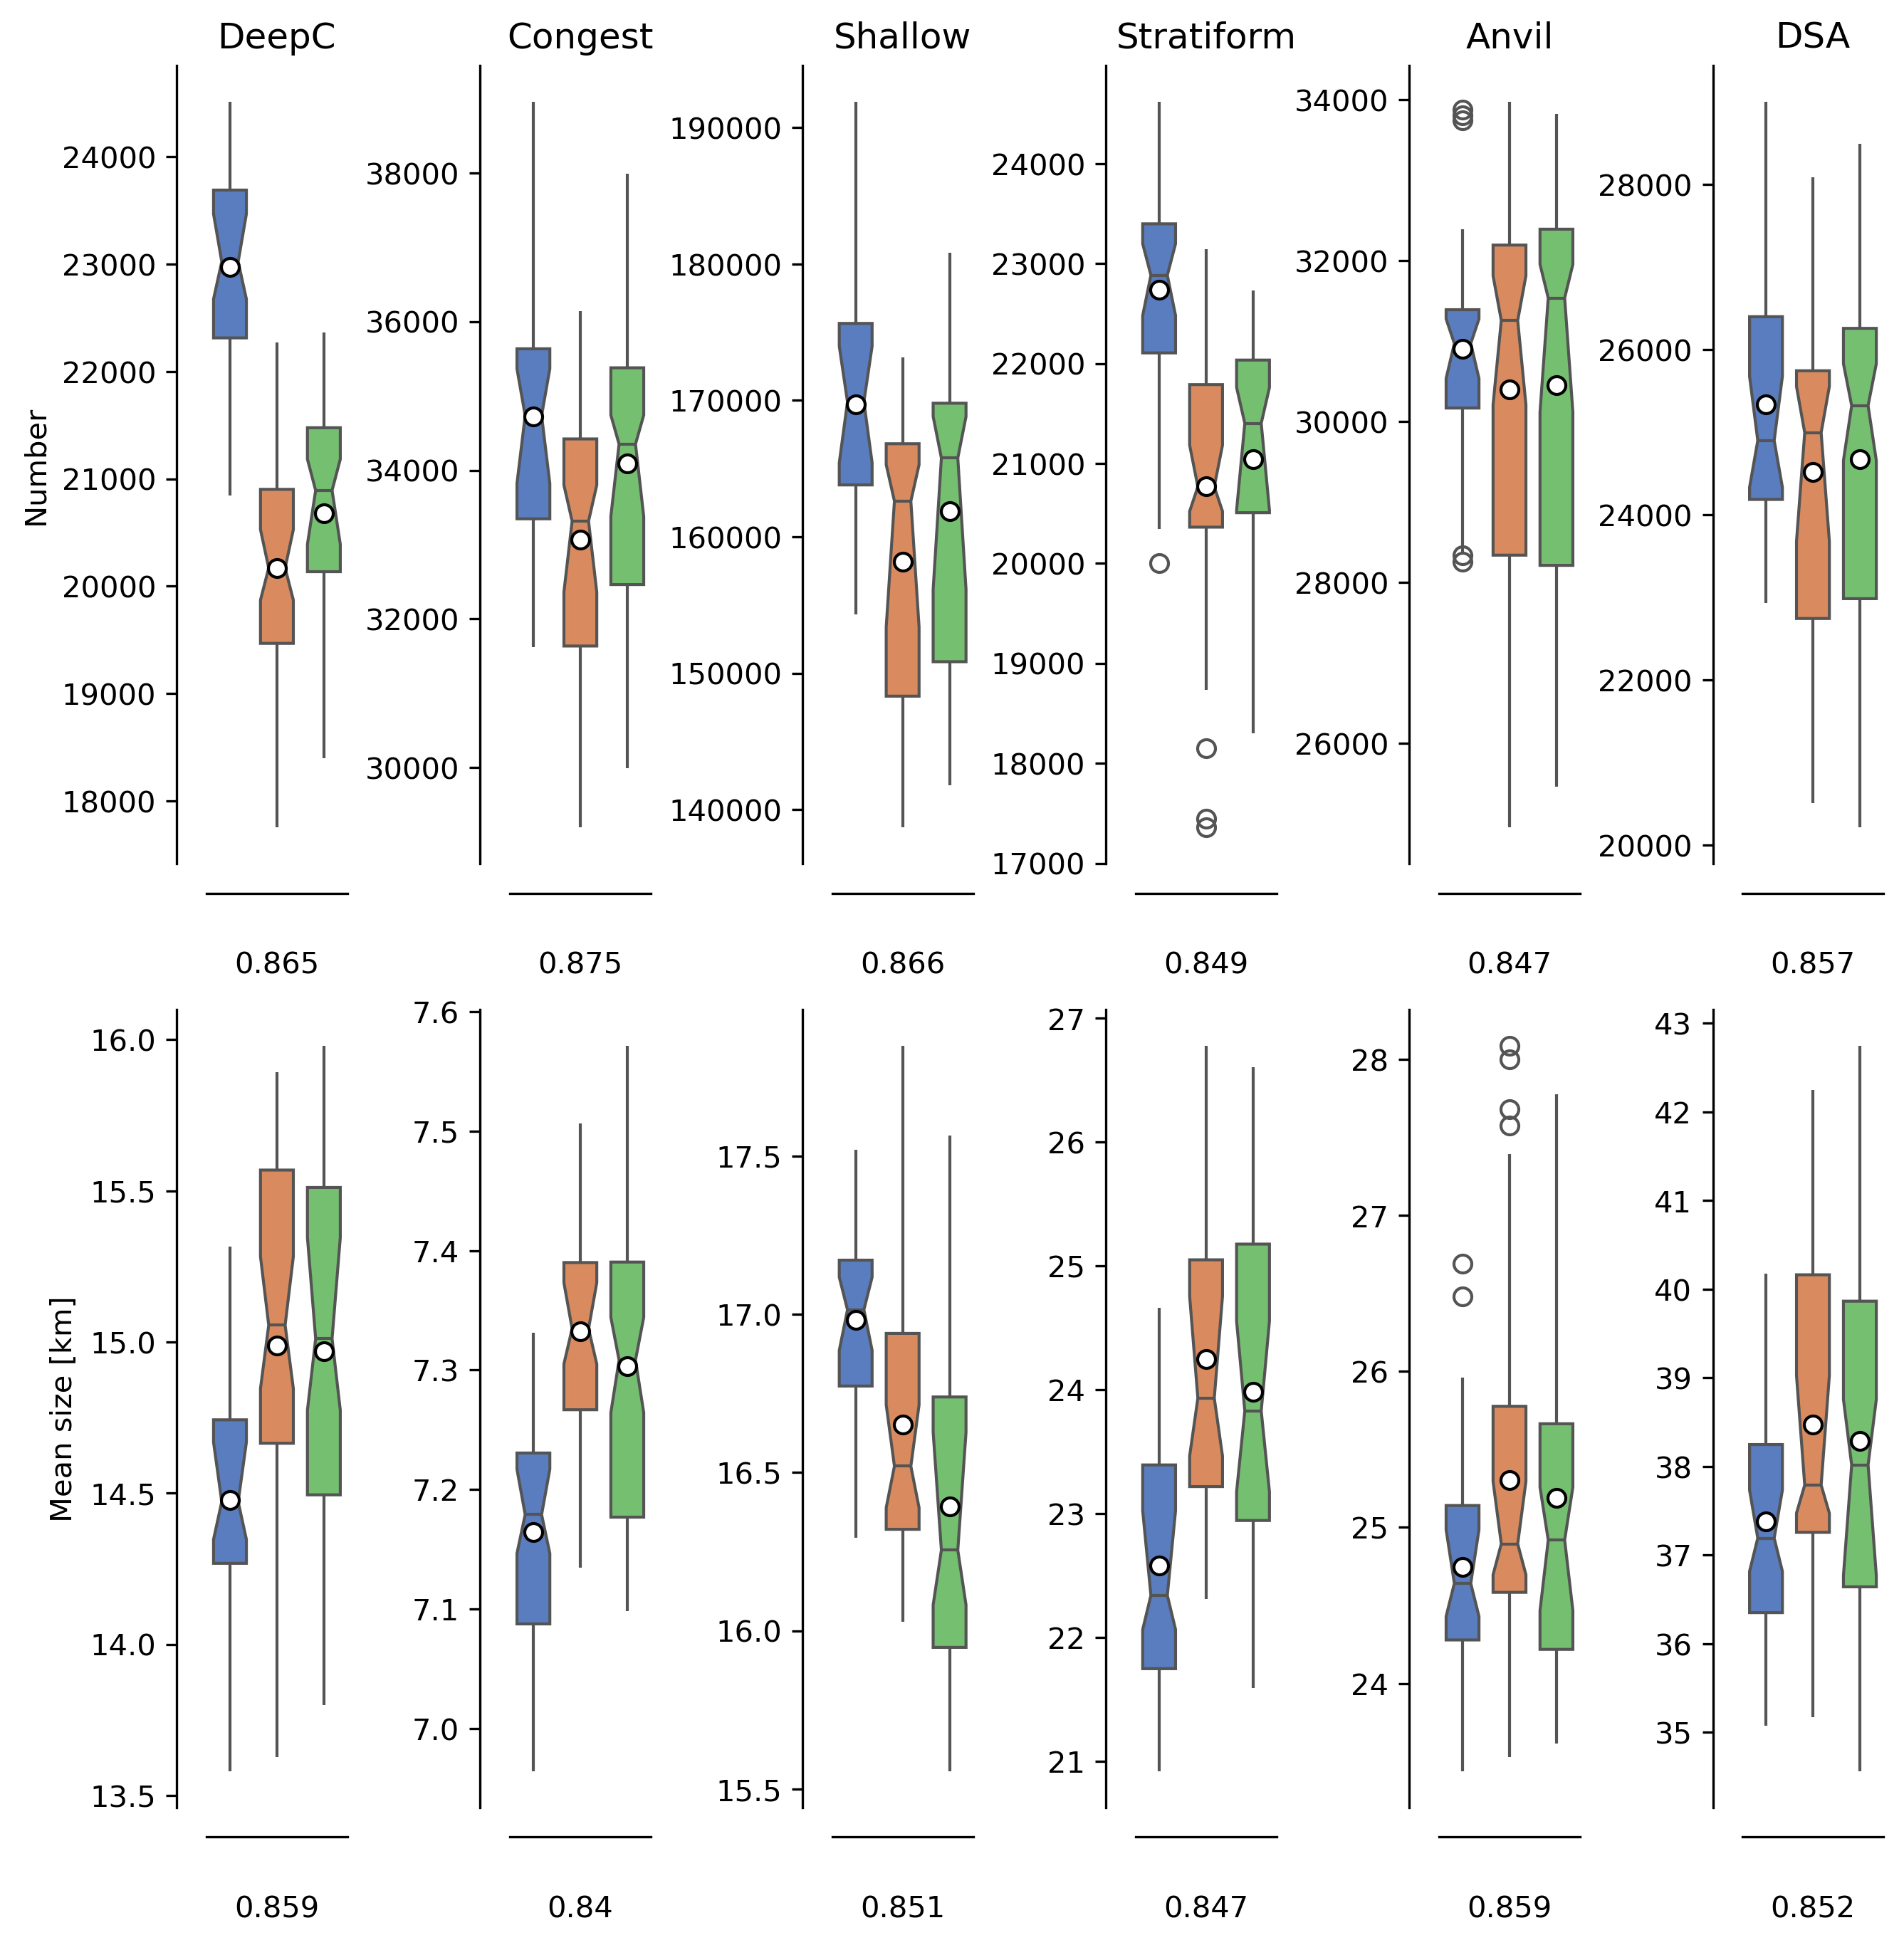

In [56]:
from scipy.stats import ttest_ind
import seaborn as sns

def plot_boxplots(pltvar, axs, do_legend=False):
      colors = sns.color_palette('muted', n_colors=ntest)
      for iclass, iax in enumerate(axs):
            sns.boxplot([pltvar[iexp,:,iclass] for iexp in range(pltvar.shape[0])],
                        width=0.7, showmeans=True,
                        meanprops={"marker":"o", "markerfacecolor":"white",
                              "markeredgecolor":"black", "markersize":"6"},
                        palette=colors,
                        ax=iax, notch=True, showcaps=False, bootstrap=10000,
                        showfliers=True,)
            sns.despine(ax=iax, bottom=True)

            # Add t-test
            t_stat, p_value = ttest_ind(pltvar[0,iclass,:],
                                    pltvar[1,iclass,:],
                                    equal_var=True)
            iax.text(0.5, -0.11, str(np.round(p_value, 3)),
                     ha='center', va='top', transform=iax.transAxes)#, fontsize=10)
      # if do_legend:
      #       axs[-1].legend(loc="upper right", frameon=False, fontsize=12, labels=test_names, bbox_to_anchor=(1.15, 0.5))
      #       handles = [plt.Line2D([0], [0], color=colors[i], lw=10) for i in range(ntest)]
      #       axs[-1].legend(handles=handles, labels=test_names, loc="center right", frameon=False,
      #                      fontsize=12, bbox_to_anchor=(5.0, 0.5))
      return axs

# create figure
fig_x = 1.3*nclass + 1
fig_y = 9
fig, axs = plt.subplots(2,nclass, figsize=(fig_x,fig_y), layout="constrained", dpi=300)

# Cluster counts
pltvar = numbers
ytitle = 'Number'
irow = 0
axs[irow, 0].set_ylabel(ytitle)
# plot_boxplots(pltvar, axs.flatten()[0:nclass], ntest, it_max, ytitle, do_legend=True)
axs[irow,:] = plot_boxplots(pltvar[:,:,:], axs[irow,:])

# Cluster sizes
pltvar = mean_sizes/1e3 # m --> km
ytitle = 'Mean size [km]'
# plot_boxplots(pltvar, axs.flatten()[nclass:nclass*2], ntest, it_max, ytitle, do_legend=True)
irow = 1
axs[irow, 0].set_ylabel(ytitle)
axs[irow,:] = plot_boxplots(pltvar[:,:,:], axs[irow,:])

for iclass in range(nclass):
      axs[0,iclass].set_title(pclass_names_long[iclass])

for iaxs in axs.flatten():
      sns.despine(offset=10,ax=iaxs, top=True, right=True)
      iaxs.set_xticks([])

# axs[1,nclass-1].legend(loc="upper right", labels=test_names,
#                        frameon=False, fontsize=12, bbox_to_anchor=(1.15, 0.5))

plt.show()

In [ ]:
# def do_tser(figdata, do_legend=False):
#     ntest = figdata['number'].shape[0]
#     smooth=True
#     # smooth=False
#     fig_x, fig_y = 6, 6
#     fig, ax = plt.subplots(2,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
#     ax[0].set_title(figdata['units'])
#     # ax[0].set_title('Mean Diamater [km]')
#     # ax[1].set_title('Number [km]')
#     ax[0].set_ylabel('Number')
#     # ax[1].set_ylabel('Mean radius [km]')
#     ax[1].set_ylabel('Mean area [km$^2$]')
#     # ax[0].set_xlabel('Time [hour]')
#     ax[1].set_xlabel('Time [hour]')
#     linecolor=['black', 'red', 'blue', 'green', 'green']
#     # linecolor=['red', 'blue', 'green', 'green']
#     linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
#     linestyle[-1]='dashed'
#     for iax in range(2):
#         if iax == 0:
#             pltvar = figdata['number']
#         else:
#             pltvar = figdata['size']
#         for itest in range(ntest):
#             pvar = pltvar[itest]
#             if smooth:
#                 pvar = do_smooth(pvar)
#             mean, low, high = mean_confidence_interval(pvar)
#             ax[iax].plot(mean, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
#             # var_smooth = pd.DataFrame(mean)
#             # var_smooth = var_smooth.rolling(window=3, center=True, closed='both').mean()
#             # ax[iprof].plot(var_smooth, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
#             # if (itest == 0) or (itest == 1):
#             xdim = range(0,mean.shape[0])
#             ax[iax].fill_between(xdim, high, low, alpha=0.2, color=linecolor[itest])
#     if do_legend:
#         plt.legend(loc='upper left', prop={'size': 10})
#     plt.show()
#     plt.close()

In [ ]:
# # area_grid_cell = 9 # km**2
# # diam = 2*np.sqrt((mean_size*area_grid_cell)/np.pi)
# sizes_sqrt = np.sqrt(mean_size*delta_x2)

# def ctldiff(invar):
#     return invar - invar[0,...]
#     # return invar
#     # ctl_ensmean = np.mean(invar[0,...], axis=0)
#     # return invar - ctl_ensmean[np.newaxis,np.newaxis,...]

# # Difference from CTL
# number_ctlanom = ctldiff(number)
# # radius_ctlanom = ctldiff(radius)
# # mean_size_ctlanom = ctldiff(mean_size)
# mean_size_ctlanom = ctldiff(sizes_sqrt)

# figdata = {
#     # 'size': diam, # dims = (ntest, nmem, npclass, nt)
#     # 'size': mean_size, # dims = (ntest, nmem, npclass, nt)
#     # 'number': number, # dims = (ntest, nmem, npclass, nt)
#     'size': mean_size_ctlanom[1:], # dims = (ntest, nmem, npclass, nt)
#     'number': number_ctlanom[1:], # dims = (ntest, nmem, npclass, nt)
#     'tests_str': tests_str[1:],
#     'units': pclass_names,
#     }

# do_legend=True
# # if kpclass == npclass-1:
# #     do_legend=True

# do_tser(figdata, do_legend=do_legend)